## **Retrieval-Augmented Generation (RAG)**

Retrieval-augmented generation (RAG) is an innovative approach in the field of natural language processing (NLP) that combines the strengths of retrieval-based and generation-based models to enhance the quality of generated text. This hybrid model aims to leverage the vast amounts of information available in large-scale databases or knowledge bases, making it particularly effective for tasks that require accurate and contextually relevant information.

In this tutorial, we will cover the following key steps:

1. Setting up the Azure Search Index: Explanation on creating and configuring an Azure Search index for storing and retrieving information.

2. Initializing Azure Search and Langchain Components: Setting up the necessary components like the Azure Search Retriever and Azure OpenAI model.

3. Defining a Prompt for the Language Model: Structuring how the retrieved context and user questions are passed to the language model.

4. Building a RAG Chain: Combining the retrieval and generation processes into a chain that retrieves relevant context and generates answers.

5. Running the Chatbot: Implementing an interactive loop to allow users to input questions and receive responses grounded in retrieved context.

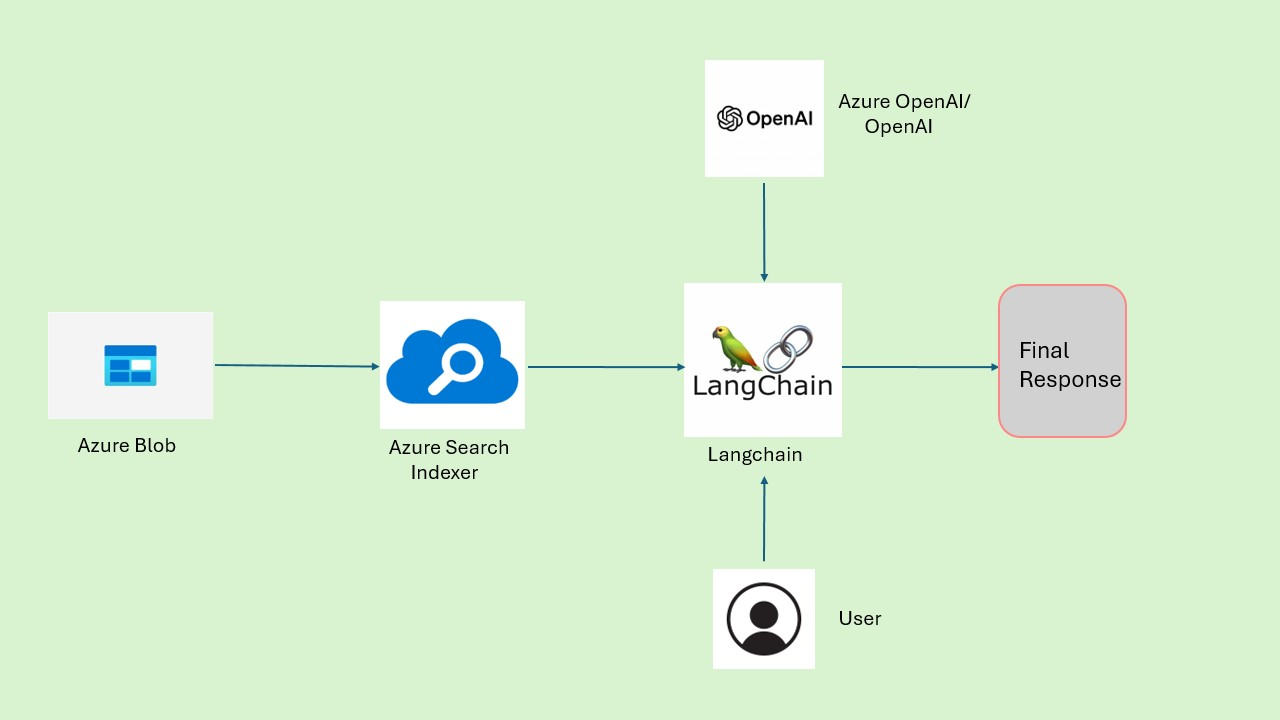

### Step 1: Import Azure Open AI Model

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from openai import AzureOpenAI
from langchain.chat_models import AzureChatOpenAI

AZURE_API_CLIENT = os.getenv("AZURE_API_CLIENT")
AZURE_API_KEY = os.getenv("AZURE_API_KEY")

llm = AzureChatOpenAI(
    azure_deployment="my-first-gpt",   # The name of your deployed model in Azure
    api_version="2025-01-01-preview",
    azure_endpoint=AZURE_API_CLIENT,
    api_key=AZURE_API_KEY
)

/var/folders/f0/hbgqnpxj3y120xjbg_znbfpc0000gn/T/ipykernel_34060/955407364.py:10: LangChainDeprecationWarning: The class `AzureChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import AzureChatOpenAI``.
  llm = AzureChatOpenAI(


### Step 2: Create Azure Table based on Local File

In [ ]:
#Create an Azure Table based on the File / Private Knowledge Base
import csv
from azure.data.tables import TableServiceClient, TableEntity

# Set up your Azure Table Storage connection
connection_string = "DefaultEndpointsProtocol=https;AccountName=tjdatastore;AccountKey=Skg/05OzgEPeEI+c3cKXBq9+mFAyuX0jm4l+8AgT3okW/+vk/l3m7nPT5DkBb/SShkpqpJbI5LPy+ASt0FG0gQ==;EndpointSuffix=core.windows.net"
table_name = "BMWDATA"

# Create a TableServiceClient
table_service = TableServiceClient.from_connection_string(conn_str=connection_string)

# Create a table if it doesn't exist
try:
    table_service.create_table(table_name)
except Exception as e:
    print(f"Table already exists: {e}")

# Read the CSV file and upload the data
csv_file_path = "bmw.csv"

with open(csv_file_path, mode='r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        # Create a new entity
        entity = TableEntity()
        entity['PartitionKey'] = "BMW_FAQ"  # You can set this to whatever makes sense
        entity['RowKey'] = row['ID']  # Use ID as RowKey
        entity['Question'] = row['Question']
        entity['Answer'] = row['Answer']

        # Upload the entity to the table
        table_service.get_table_client(table_name).create_entity(entity=entity)
        print(f"Uploaded: {entity['RowKey']} - {entity['Question']}")

print("Data upload complete.")


### Step 3: Set Up Azure AI Search

- Before running the code, make sure to create an Azure Cognitive Search index:
      - Set Up Azure Search Service:
      - Log in to the Azure portal. Search for "Azure Cognitive Search" and click Create. Provide details like Subscription, Resource Group, Service Name, and Region, then create the service.
- Create an Index with Import Data:
    
    - Once the service is created, go to Overview > Import Data. Choose a data source (like Azure Blob Storage, SQL Database, or custom data). 
     - Follow the prompts to select your data and configure the fields (e.g., id, Answer). The system will create the index automatically based on your data structure.
- Set Environment Variables: After creating the index, set the necessary environment variables

### Step 4: Set the environment variables for Azure AI Search

In [2]:
# These variables configure the search service and index for retrieving documents

# Set the Azure AI Search service name
os.environ["AZURE_AI_SEARCH_SERVICE_NAME"] = "ai-search-tj"
# Set the Azure AI Search index name to query
os.environ["AZURE_AI_SEARCH_INDEX_NAME"] = "rag-tj"
# Set the Azure AI Search API key for authentication
os.environ["AZURE_AI_SEARCH_API_KEY"] = "yach2na8X8YMkmJcA9o3DT2zHdxx65MjgWbcW2HRJxAzSeC9jGrE"

### Step 4: **Initialize the Retriever, Prompt, and LLM**

In [5]:
# Import necessary libraries and modules from Langchain
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import AzureChatOpenAI
from langchain_community.retrievers import AzureAISearchRetriever

# Step 1: Initialize the AzureAI Search Retriever
# This retrieves relevant documents based on the user query from the Azure Search index
retriever = AzureAISearchRetriever(
    content_key="Answer",  # The key for the content field in the search results change it accordingly as per your data
    top_k=1,              # Number of top results to retrieve
    index_name="rag-tj"  # Name of the Azure Search index to query
)

# Step 2: Define the prompt template for the language model
# This sets up how the context and question will be formatted for the model
prompt = ChatPromptTemplate.from_template(
    """Answer the question based only on the context provided.
Context: {context}  # Placeholder for the context from the retriever
Question: {question}  # Placeholder for the user question"""
)

#### **Processing Chain and User Input Loop**

In [6]:
# Step 4: Create a processing chain
# This chain will process the retrieved context and the user question
chain = (
    {"context": retriever , "question": RunnablePassthrough()}  # Set context using the retriever and format it
    | prompt                                                    # Pass the formatted context and question to the prompt
    | llm                                                       # Generate a response using the language model
    | StrOutputParser()                                         # Parse the output to a string format
)

# Step 5: Infinite loop for user input
while True:
    user_question = input("Please enter your question (or type 'end' to exit): ")
    if user_question.lower() == "end":
        print("Exiting the loop. Goodbye!")
        break

    # Pass input as a dict matching the chain keys
    response = chain.invoke({"question": user_question})
    print("Response:", response)

Response: The context provided does not specify any particular BMW model. It only mentions that BMW is committed to electric vehicles, offering several models and investing in sustainable battery technology.
Response: Based on the provided context, BMW is committed to electric vehicles, offering several models and investing in sustainable battery technology. This indicates that BMW is indeed focusing significantly on electric vehicles as part of their strategy.
Exiting the loop. Goodbye!
